# Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.feature_selection import SelectKBest, f_classif, RFE, SelectFromModel
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.semi_supervised import LabelSpreading, LabelPropagation
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# 1. DATA LOADING & EXPLORATION

## Load training data (400 samples)

In [2]:
train_df = pd.read_csv('train.csv')
train_labels_df = pd.read_csv('train_labels.csv')
test_df = pd.read_csv('test.csv')

print(f"Training data shape: {train_df.shape}")
print(f"Labeled training data shape: {train_labels_df.shape}")
print(f"Test data shape: {test_df.shape}")

Training data shape: (400, 14574)
Labeled training data shape: (150, 2)
Test data shape: (401, 14573)


## Extract gene features

In [3]:
gene_cols = [col for col in train_df.columns if col.startswith('gene_')]
print(f"Number of gene features: {len(gene_cols)}")

Number of gene features: 14572


## Data Exploration

In [4]:
labeled_count = train_df['Class'].notna().sum()
unlabeled_count = train_df['Class'].isna().sum()
print(f"\nLabeled samples: {labeled_count}")
print(f"Unlabeled samples: {unlabeled_count}")


Labeled samples: 150
Unlabeled samples: 250


## Class Distribution

In [5]:

class_dist = train_labels_df['Class'].value_counts().sort_index()
print(f"\nClass distribution:")
for i, count in class_dist.items():
    print(f"  Class {i}: {count} samples ({count/len(train_labels_df)*100:.1f}%)")



Class distribution:
  Class 0: 26 samples (17.3%)
  Class 1: 26 samples (17.3%)
  Class 2: 56 samples (37.3%)
  Class 3: 15 samples (10.0%)
  Class 4: 27 samples (18.0%)


# 2. EDA ANALYSIS

## Missing values analysis

In [6]:
print(f"\n❓ Missing Values Analysis:")
missing_train = train_df.isnull().sum()
missing_genes = missing_train[gene_cols].sum()
print(f"  • Missing values in gene features: {missing_genes}")
print(f"  • Missing class labels (expected): {train_df['Class'].isnull().sum()}")



❓ Missing Values Analysis:
  • Missing values in gene features: 482046
  • Missing class labels (expected): 250


## Class distribution analysis

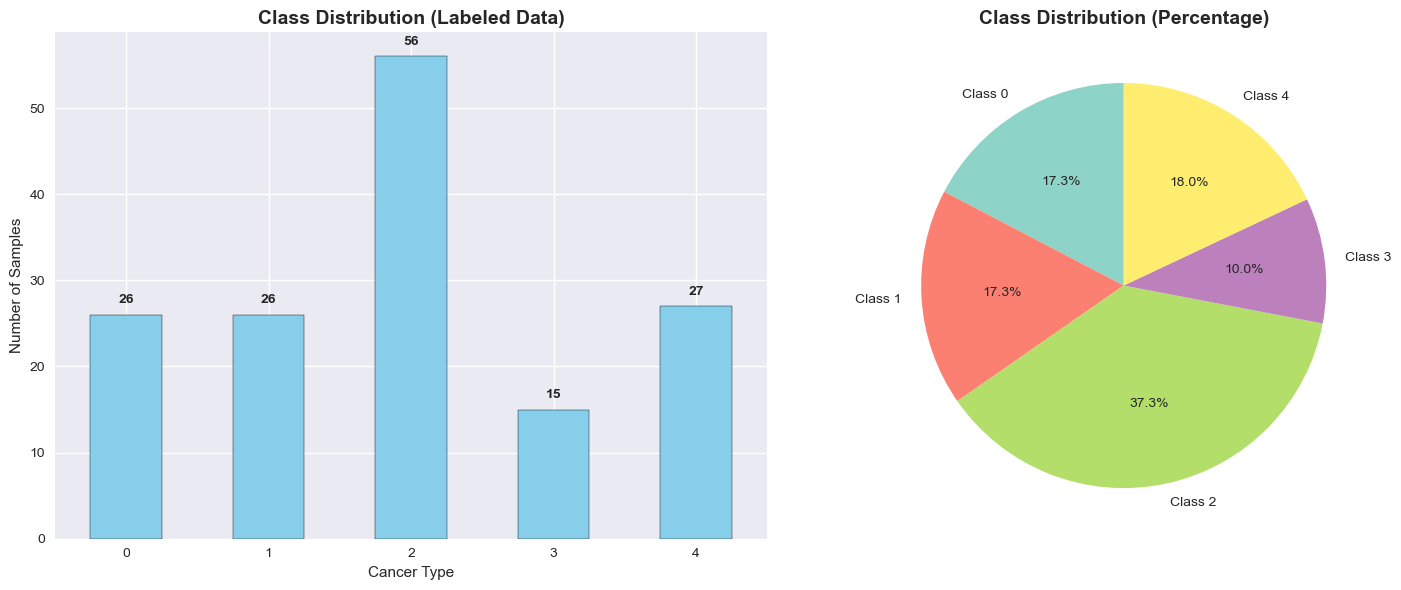

In [7]:
# Class distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Bar plot
class_dist.plot(kind='bar', ax=axes[0], color='skyblue', edgecolor='black')
axes[0].set_title('Class Distribution (Labeled Data)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Cancer Type')
axes[0].set_ylabel('Number of Samples')
axes[0].tick_params(axis='x', rotation=0)

# Add value labels on bars
for i, v in enumerate(class_dist.values):
    axes[0].text(i, v + 1, str(v), ha='center', va='bottom', fontweight='bold')

# Pie chart
colors = plt.cm.Set3(np.linspace(0, 1, len(class_dist)))
axes[1].pie(class_dist.values, labels=[f'Class {i}' for i in class_dist.index], 
           autopct='%1.1f%%', colors=colors, startangle=90)
axes[1].set_title('Class Distribution (Percentage)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


## Gene Expression Distribution Analysis

📈 Overall Gene Expression Statistics:
  • Mean expression: 0.005
  • Median expression: -0.101
  • Standard deviation: 1.035
  • Min expression: -22.899
  • Max expression: 21.708


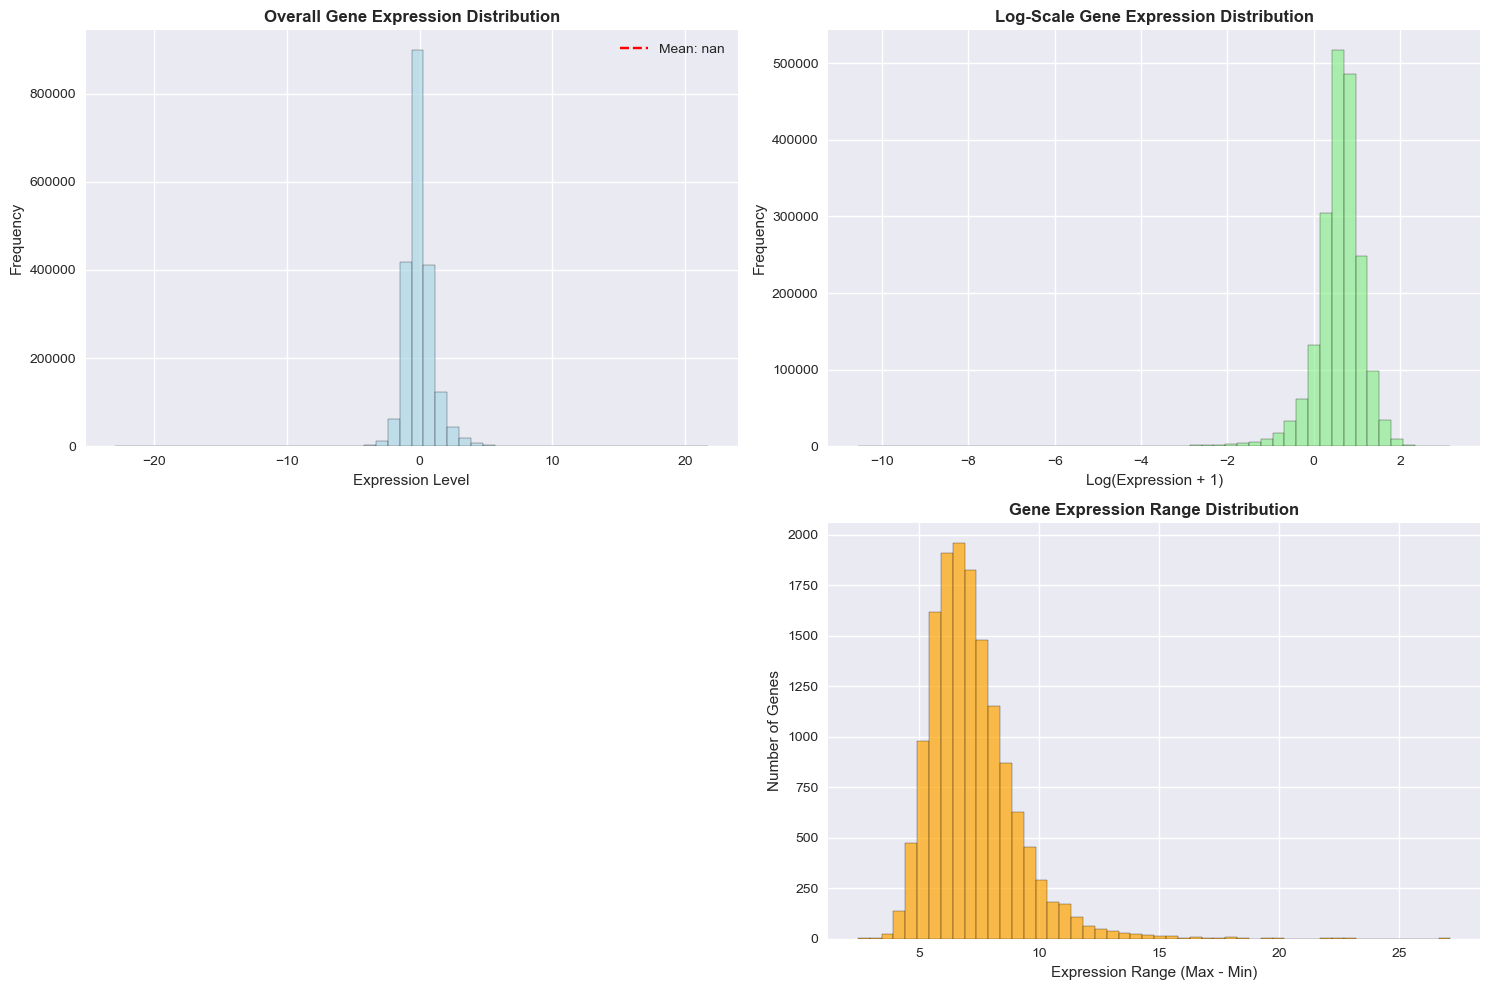

In [ ]:
# Sample random genes for analysis
np.random.seed(42)
sample_genes = np.random.choice(gene_cols, size=min(20, len(gene_cols)), replace=False)

# Preparing data for class-specific analysis
labeled_mask = train_df['Class'].notna()
X_labeled = train_df[labeled_mask][gene_cols]
y_labeled = train_df[labeled_mask]['Class'].astype(int)

# Overall statistics
gene_stats = X_labeled[gene_cols].describe()
print(f"📈 Overall Gene Expression Statistics:")
print(f"  • Mean expression: {gene_stats.loc['mean'].mean():.3f}")
print(f"  • Median expression: {gene_stats.loc['50%'].median():.3f}")
print(f"  • Standard deviation: {gene_stats.loc['std'].mean():.3f}")
print(f"  • Min expression: {gene_stats.loc['min'].min():.3f}")
print(f"  • Max expression: {gene_stats.loc['max'].max():.3f}")

# Distribution plots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Overall distribution histogram
all_expressions = X_labeled[gene_cols].values.flatten()
axes[0, 0].hist(all_expressions, bins=50, alpha=0.7, color='lightblue', edgecolor='black')
axes[0, 0].set_title('Overall Gene Expression Distribution', fontweight='bold')
axes[0, 0].set_xlabel('Expression Level')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(np.mean(all_expressions), color='red', linestyle='--', 
                   label=f'Mean: {np.mean(all_expressions):.3f}')
axes[0, 0].legend()

# 2. Log-scale distribution
log_expressions = np.log1p(all_expressions + 1)  # Adding 1 to handle zeros
axes[0, 1].hist(log_expressions, bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0, 1].set_title('Log-Scale Gene Expression Distribution', fontweight='bold')
axes[0, 1].set_xlabel('Log(Expression + 1)')
axes[0, 1].set_ylabel('Frequency')

# 3. Expression range by gene
gene_ranges = X_labeled[gene_cols].max() - X_labeled[gene_cols].min()
axes[1, 1].hist(gene_ranges, bins=50, alpha=0.7, color='orange', edgecolor='black')
axes[1, 1].set_title('Gene Expression Range Distribution', fontweight='bold')
axes[1, 1].set_xlabel('Expression Range (Max - Min)')
axes[1, 1].set_ylabel('Number of Genes')


fig.delaxes(axes[1, 0])

plt.tight_layout()
plt.show()
#

## Class-Specific Gene Expression Analysis

  • Class 0: 26 samples
  • Class 1: 26 samples
  • Class 2: 56 samples
  • Class 3: 15 samples
  • Class 4: 27 samples


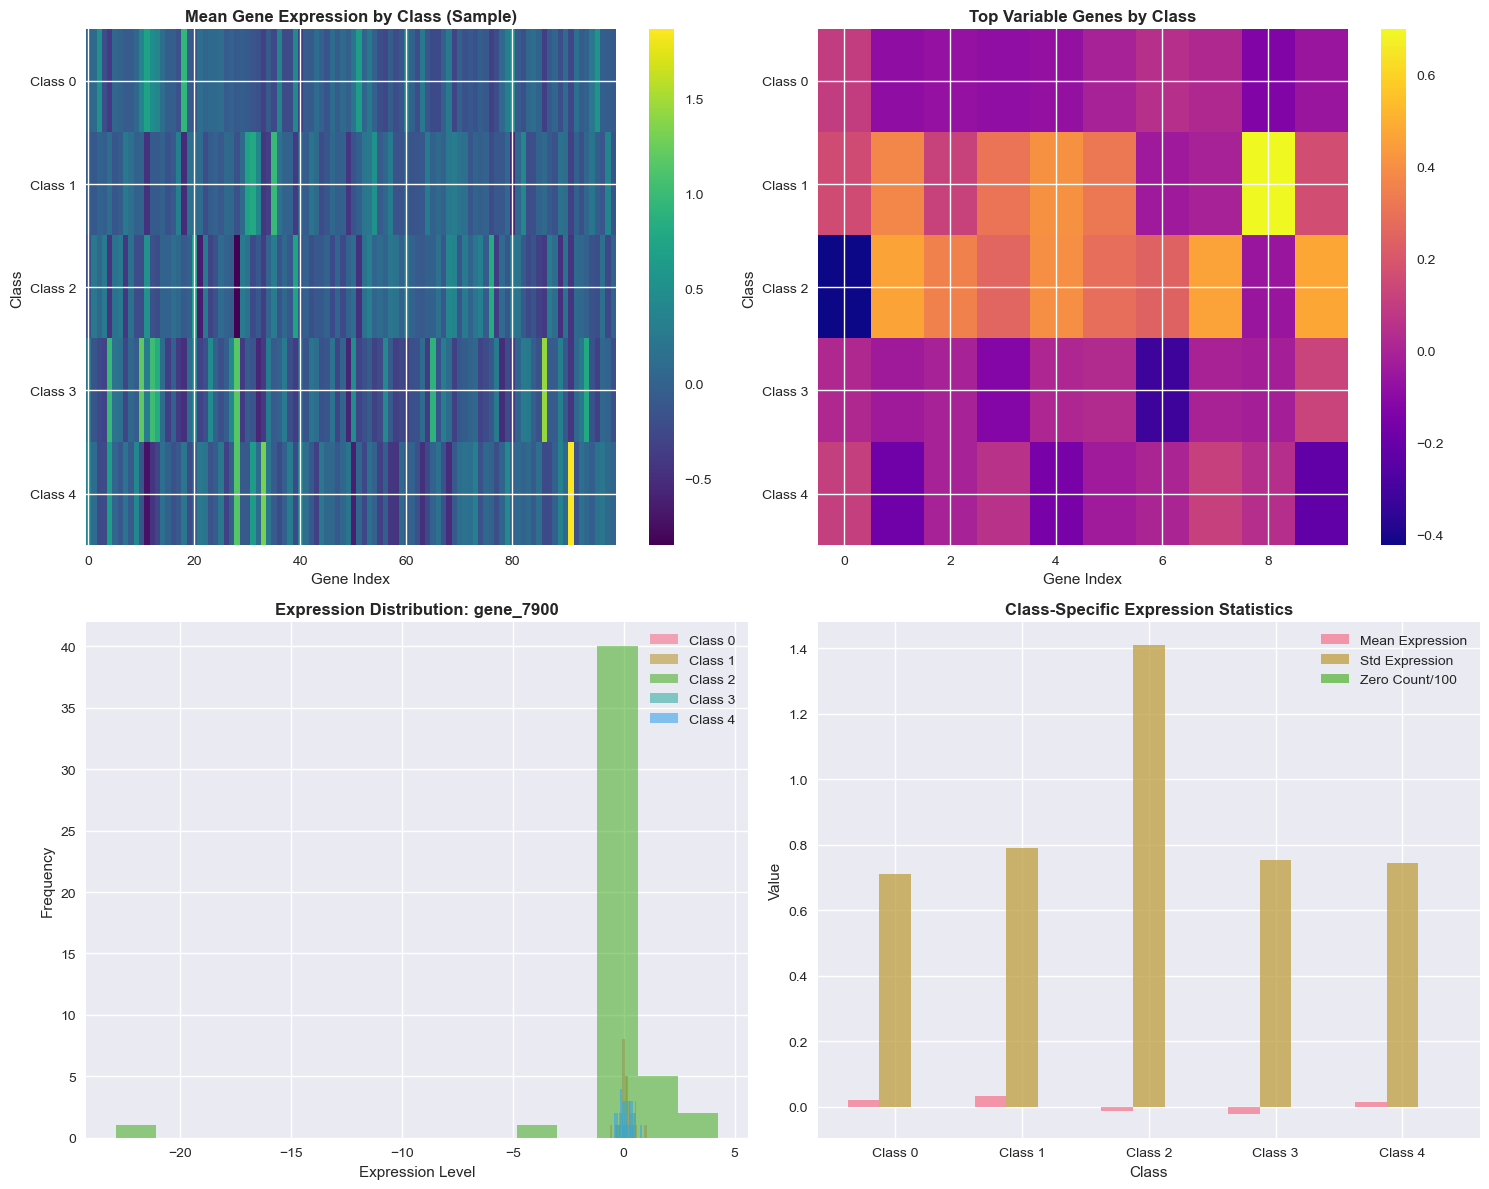

In [11]:
# Create class-specific datasets
class_data = {}
for class_label in sorted(y_labeled.unique()):
    class_mask = y_labeled == class_label
    class_data[class_label] = X_labeled[class_mask]
    print(f"  • Class {class_label}: {class_mask.sum()} samples")

# Sample genes for detailed analysis
top_var_genes = X_labeled[gene_cols].var().nlargest(10).index.tolist()

# Class-specific expression patterns
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Mean expression by class
class_means = pd.DataFrame({
    f'Class_{i}': class_data[i][gene_cols].mean() 
    for i in sorted(class_data.keys())
})

# Sample genes for visualization
sample_genes_idx = np.random.choice(len(gene_cols), size=min(100, len(gene_cols)), replace=False)
sample_class_means = class_means.iloc[sample_genes_idx]

im1 = axes[0, 0].imshow(sample_class_means.T, cmap='viridis', aspect='auto')
axes[0, 0].set_title('Mean Gene Expression by Class (Sample)', fontweight='bold')
axes[0, 0].set_xlabel('Gene Index')
axes[0, 0].set_ylabel('Class')
axes[0, 0].set_yticks(range(len(class_data)))
axes[0, 0].set_yticklabels([f'Class {i}' for i in sorted(class_data.keys())])
plt.colorbar(im1, ax=axes[0, 0])

# 2. Top variable genes by class
top_genes_data = pd.DataFrame({
    f'Class_{i}': class_data[i][top_var_genes].mean() 
    for i in sorted(class_data.keys())
})

im2 = axes[0, 1].imshow(top_genes_data.T, cmap='plasma', aspect='auto')
axes[0, 1].set_title('Top Variable Genes by Class', fontweight='bold')
axes[0, 1].set_xlabel('Gene Index')
axes[0, 1].set_ylabel('Class')
axes[0, 1].set_yticks(range(len(class_data)))
axes[0, 1].set_yticklabels([f'Class {i}' for i in sorted(class_data.keys())])
plt.colorbar(im2, ax=axes[0, 1])

# 3. Distribution comparison for a highly variable gene
high_var_gene = X_labeled[gene_cols].var().idxmax()
for i, class_label in enumerate(sorted(class_data.keys())):
    class_expr = class_data[class_label][high_var_gene]
    axes[1, 0].hist(class_expr, bins=15, alpha=0.6, label=f'Class {class_label}')

axes[1, 0].set_title(f'Expression Distribution: {high_var_gene}', fontweight='bold')
axes[1, 0].set_xlabel('Expression Level')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].legend()

# 4. Class separation analysis
class_stats = pd.DataFrame({
    'Class': [],
    'Mean_Expression': [],
    'Std_Expression': [],
    'Zero_Count': []
})

for class_label in sorted(class_data.keys()):
    class_expr = class_data[class_label][gene_cols]
    mean_expr = class_expr.mean(axis=1).mean()
    std_expr = class_expr.std(axis=1).mean()
    zero_count = (class_expr == 0).sum(axis=1).mean()
    
    new_row = pd.DataFrame({
        'Class': [class_label],
        'Mean_Expression': [mean_expr],
        'Std_Expression': [std_expr],
        'Zero_Count': [zero_count]
    })
    class_stats = pd.concat([class_stats, new_row], ignore_index=True)

# Plot class statistics
x = np.arange(len(class_stats))
width = 0.25

axes[1, 1].bar(x - width, class_stats['Mean_Expression'], width, label='Mean Expression', alpha=0.7)
axes[1, 1].bar(x, class_stats['Std_Expression'], width, label='Std Expression', alpha=0.7)
axes[1, 1].bar(x + width, class_stats['Zero_Count']/100, width, label='Zero Count/100', alpha=0.7)

axes[1, 1].set_title('Class-Specific Expression Statistics', fontweight='bold')
axes[1, 1].set_xlabel('Class')
axes[1, 1].set_ylabel('Value')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels([f'Class {int(i)}' for i in class_stats['Class']])
axes[1, 1].legend()

plt.tight_layout()
plt.show()


## Dimensionality Reduction Analysis

Performing PCA analysis...
📊 PCA Results:
  • Components for 90% variance: 1
  • Components for 95% variance: 1
  • First 10 components explain: 0.151 of variance


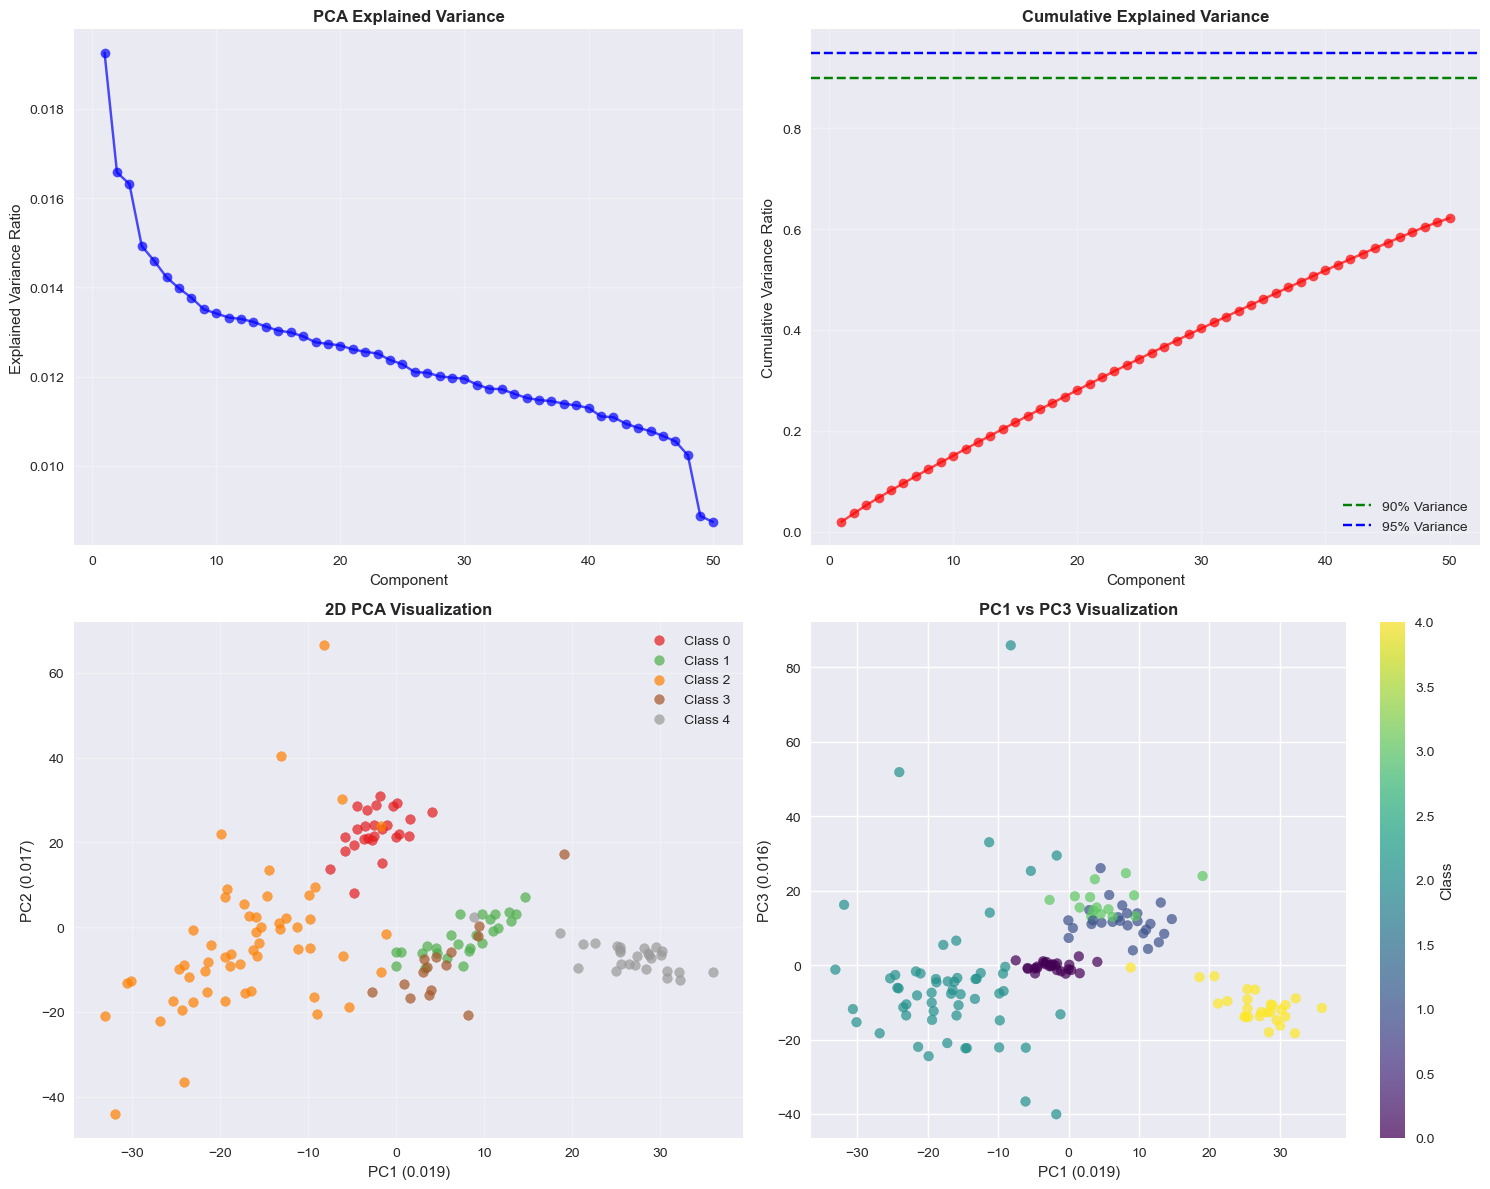

In [12]:
# PCA Analysis
print("Performing PCA analysis...")

# Fill NaN values before PCA
X_labeled_filled = X_labeled[gene_cols].fillna(X_labeled[gene_cols].median())

pca = PCA(n_components=min(50, len(gene_cols), len(X_labeled_filled)))
X_pca = pca.fit_transform(X_labeled_filled)

# Explained variance
cumsum_var = np.cumsum(pca.explained_variance_ratio_)
n_components_90 = np.argmax(cumsum_var >= 0.9) + 1
n_components_95 = np.argmax(cumsum_var >= 0.95) + 1

print(f"📊 PCA Results:")
print(f"  • Components for 90% variance: {n_components_90}")
print(f"  • Components for 95% variance: {n_components_95}")
print(f"  • First 10 components explain: {cumsum_var[9]:.3f} of variance")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Explained variance
axes[0, 0].plot(range(1, len(pca.explained_variance_ratio_) + 1), 
                pca.explained_variance_ratio_, 'bo-', alpha=0.7)
axes[0, 0].set_title('PCA Explained Variance', fontweight='bold')
axes[0, 0].set_xlabel('Component')
axes[0, 0].set_ylabel('Explained Variance Ratio')
axes[0, 0].grid(True, alpha=0.3)

# 2. Cumulative explained variance
axes[0, 1].plot(range(1, len(cumsum_var) + 1), cumsum_var, 'ro-', alpha=0.7)
axes[0, 1].axhline(y=0.9, color='g', linestyle='--', label='90% Variance')
axes[0, 1].axhline(y=0.95, color='b', linestyle='--', label='95% Variance')
axes[0, 1].set_title('Cumulative Explained Variance', fontweight='bold')
axes[0, 1].set_xlabel('Component')
axes[0, 1].set_ylabel('Cumulative Variance Ratio')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. 2D PCA visualization
colors = plt.cm.Set1(np.linspace(0, 1, len(np.unique(y_labeled))))
for i, class_label in enumerate(sorted(np.unique(y_labeled))):
    mask = y_labeled == class_label
    axes[1, 0].scatter(X_pca[mask, 0], X_pca[mask, 1], 
                      c=[colors[i]], label=f'Class {class_label}', alpha=0.7)

axes[1, 0].set_title('2D PCA Visualization', fontweight='bold')
axes[1, 0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.3f})')
axes[1, 0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.3f})')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. 3D PCA (projected to 2D)
axes[1, 1].scatter(X_pca[:, 0], X_pca[:, 2], c=y_labeled, cmap='viridis', alpha=0.7)
axes[1, 1].set_title('PC1 vs PC3 Visualization', fontweight='bold')
axes[1, 1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.3f})')
axes[1, 1].set_ylabel(f'PC3 ({pca.explained_variance_ratio_[2]:.3f})')
cbar = plt.colorbar(axes[1, 1].collections[0], ax=axes[1, 1])
cbar.set_label('Class')

plt.tight_layout()
plt.show()


## Correlation Analysis

Analyzing gene correlations...
🔗 Correlation Statistics (sample of 100 genes):
  • High correlation pairs (|r| > 0.8): 0
  • Mean absolute correlation: 0.096
  • Max correlation: 1.000


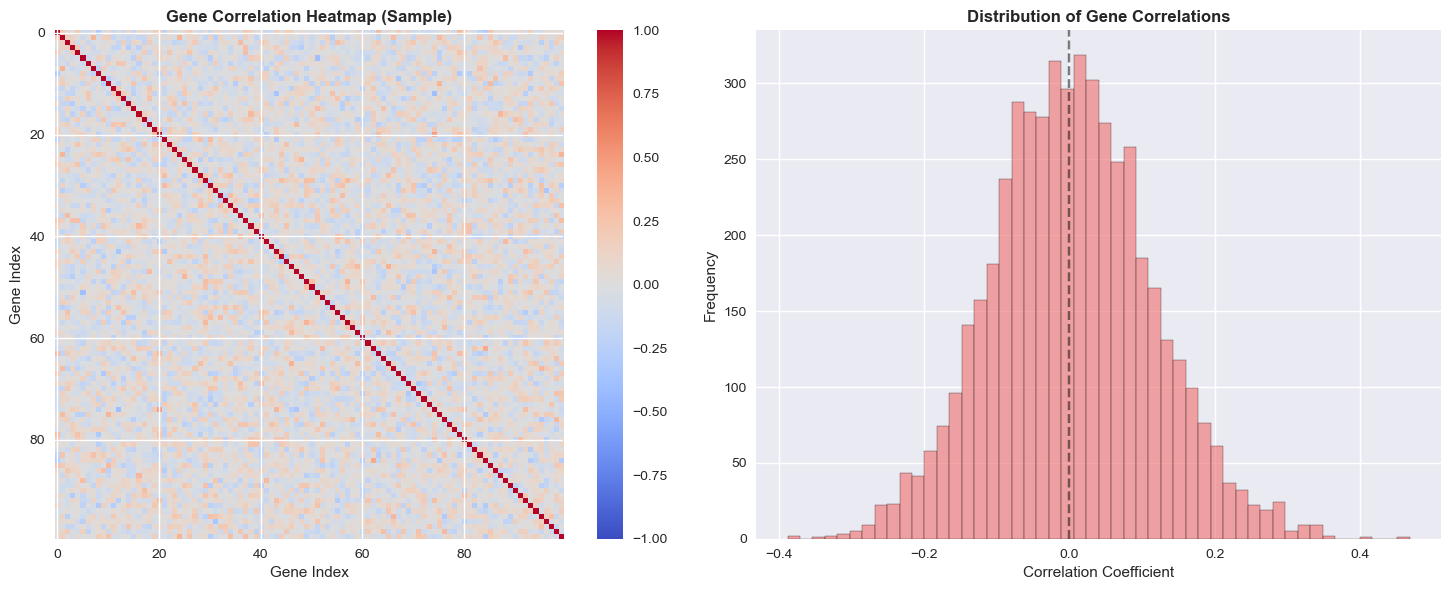

In [13]:
# Sample correlation analysis (subset of genes due to computational constraints)
print("Analyzing gene correlations...")
sample_genes_corr = np.random.choice(gene_cols, size=min(100, len(gene_cols)), replace=False)
corr_matrix = X_labeled[sample_genes_corr].corr()

# Correlation statistics
high_corr_pairs = np.where(np.abs(corr_matrix) > 0.8)
high_corr_count = len(high_corr_pairs[0]) - len(corr_matrix)  # Exclude diagonal

print(f"🔗 Correlation Statistics (sample of {len(sample_genes_corr)} genes):")
print(f"  • High correlation pairs (|r| > 0.8): {high_corr_count}")
print(f"  • Mean absolute correlation: {np.abs(corr_matrix.values).mean():.3f}")
print(f"  • Max correlation: {corr_matrix.abs().max().max():.3f}")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 1. Correlation heatmap
im = axes[0].imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
axes[0].set_title('Gene Correlation Heatmap (Sample)', fontweight='bold')
axes[0].set_xlabel('Gene Index')
axes[0].set_ylabel('Gene Index')
plt.colorbar(im, ax=axes[0])

# 2. Correlation distribution
corr_values = corr_matrix.values[np.triu_indices_from(corr_matrix.values, k=1)]
axes[1].hist(corr_values, bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
axes[1].set_title('Distribution of Gene Correlations', fontweight='bold')
axes[1].set_xlabel('Correlation Coefficient')
axes[1].set_ylabel('Frequency')
axes[1].axvline(0, color='black', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


## Statistical Tests

In [14]:
# ANOVA test for class differences
print("Performing ANOVA tests for class differences...")
significant_genes = []
p_values = []

# Test a sample of genes
test_genes = np.random.choice(gene_cols, size=min(100, len(gene_cols)), replace=False)

for gene in test_genes:
    gene_data = X_labeled[gene]
    class_groups = [gene_data[y_labeled == i] for i in sorted(y_labeled.unique())]
    
    try:
        f_stat, p_val = stats.f_oneway(*class_groups)
        p_values.append(p_val)
        if p_val < 0.05:
            significant_genes.append(gene)
    except:
        p_values.append(1.0)

significant_count = len(significant_genes)
print(f"🧪 ANOVA Results (sample of {len(test_genes)} genes):")
print(f"  • Significant genes (p < 0.05): {significant_count}")
print(f"  • Percentage significant: {significant_count/len(test_genes)*100:.1f}%")
print(f"  • Mean p-value: {np.mean(p_values):.4f}")

# Normality test
print(f"\n📈 Normality Tests:")
# Test a few genes for normality
test_genes_norm = np.random.choice(gene_cols, size=min(5, len(gene_cols)), replace=False)
normal_genes = 0

for gene in test_genes_norm:
    _, p_val = stats.shapiro(X_labeled[gene][:50])  # Sample for speed
    if p_val > 0.05:
        normal_genes += 1

print(f"  • Normally distributed genes: {normal_genes}/{len(test_genes_norm)}")

Performing ANOVA tests for class differences...
🧪 ANOVA Results (sample of 100 genes):
  • Significant genes (p < 0.05): 0
  • Percentage significant: 0.0%
  • Mean p-value: nan

📈 Normality Tests:
  • Normally distributed genes: 0/5


# 3. DATA PREPROCESSING

## Prepare labeled data

In [15]:
labeled_mask = train_df['Class'].notna()
X_labeled = train_df[labeled_mask][gene_cols]
y_labeled = train_df[labeled_mask]['Class'].astype(int)

## Prepare unlabeled data for semi-supervised learning


In [16]:
X_unlabeled = train_df[~labeled_mask][gene_cols]

## Prepare test data

In [17]:
X_test = test_df[gene_cols]
test_ids = test_df['Id']

print(f"Labeled data shape: {X_labeled.shape}")
print(f"Unlabeled data shape: {X_unlabeled.shape}")
print(f"Test data shape: {X_test.shape}")

Labeled data shape: (150, 14572)
Unlabeled data shape: (250, 14572)
Test data shape: (401, 14572)


# 4. FEATURE ENGINEERING & SELECTION

## Combine all data for consistent scaling

In [18]:
X_all = pd.concat([X_labeled, X_unlabeled, X_test], ignore_index=True)

## Statistical features

In [19]:
def create_statistical_features(X):
    """Create statistical features from gene expression data"""
    features = {}
    
    # Basic statistics
    features['mean'] = X.mean(axis=1)
    features['std'] = X.std(axis=1)
    features['median'] = X.median(axis=1)
    features['q25'] = X.quantile(0.25, axis=1)
    features['q75'] = X.quantile(0.75, axis=1)
    features['iqr'] = features['q75'] - features['q25']
    features['skew'] = X.skew(axis=1)
    features['kurt'] = X.kurtosis(axis=1)
    
    # Expression level features
    features['high_expr_count'] = (X > X.quantile(0.9, axis=1).values.reshape(-1, 1)).sum(axis=1)
    features['low_expr_count'] = (X < X.quantile(0.1, axis=1).values.reshape(-1, 1)).sum(axis=1)
    features['zero_expr_count'] = (X == 0).sum(axis=1)
    
    return pd.DataFrame(features)

## Create statistical features

In [20]:
stat_features_all = create_statistical_features(X_all)

## Robust scaling for gene expression data

In [21]:
print("Applying robust scaling...")
scaler = RobustScaler()
X_all_scaled = pd.DataFrame(
    scaler.fit_transform(X_all),
    columns=gene_cols
)

Applying robust scaling...


## Split back the scaled data

In [22]:
X_labeled_scaled = X_all_scaled.iloc[:len(X_labeled)]
X_unlabeled_scaled = X_all_scaled.iloc[len(X_labeled):len(X_labeled)+len(X_unlabeled)]
X_test_scaled = X_all_scaled.iloc[len(X_labeled)+len(X_unlabeled):]

## Split statistical features

In [23]:
stat_features_labeled = stat_features_all.iloc[:len(X_labeled)]
stat_features_unlabeled = stat_features_all.iloc[len(X_labeled):len(X_labeled)+len(X_unlabeled)]
stat_features_test = stat_features_all.iloc[len(X_labeled)+len(X_unlabeled):]

## Feature selection using multiple methods

In [24]:
# 1. Univariate feature selection
X_labeled_scaled = X_labeled_scaled.fillna(X_labeled_scaled.median())
selector_univariate = SelectKBest(f_classif, k=min(2000, X_labeled_scaled.shape[1]))
X_selected_univariate = selector_univariate.fit_transform(X_labeled_scaled, y_labeled)

# 2. Tree-based feature selection
rf_selector = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_selector.fit(X_labeled_scaled, y_labeled)
feature_importance = pd.Series(rf_selector.feature_importances_, index=gene_cols)
top_features = feature_importance.nlargest(1500).index.tolist()


## Combine selected features

In [26]:
selected_features = list(set(
    np.array(gene_cols)[selector_univariate.get_support()].tolist() + 
    top_features
))
print(f"Selected {len(selected_features)} important features")

Selected 2927 important features


## Final feature sets

In [27]:
X_labeled_final = pd.concat([
    X_labeled_scaled[selected_features],
    stat_features_labeled
], axis=1)

X_unlabeled_final = pd.concat([
    X_unlabeled_scaled[selected_features],
    stat_features_unlabeled
], axis=1)

X_test_final = pd.concat([
    X_test_scaled[selected_features],
    stat_features_test
], axis=1)

print(f"Final feature dimension: {X_labeled_final.shape[1]}")


Final feature dimension: 2938


# 5. SEMI-SUPERVISED LEARNING

## Combine labeled and unlabeled data for semi-supervised learning

In [28]:
X_semi = pd.concat([X_labeled_final, X_unlabeled_final], ignore_index=True)
y_semi = np.concatenate([y_labeled, [-1] * len(X_unlabeled_final)])

## Label Spreading (more robust to noise)

In [29]:
label_spreader = LabelSpreading(
    kernel='knn',
    n_neighbors=7,
    alpha=0.2,
    max_iter=30,
    tol=1e-3
)
X_semi = X_semi.fillna(X_semi.median())
print("Training Label Spreading model...")
label_spreader.fit(X_semi, y_semi)


Training Label Spreading model...


LabelSpreading(kernel='knn')

## Get pseudo-labels for unlabeled data

In [30]:
pseudo_labels = label_spreader.transduction_[len(y_labeled):]
confidence_scores = np.max(label_spreader.label_distributions_[len(y_labeled):], axis=1)

## Select high-confidence pseudo-labeled samples

In [31]:
confidence_threshold = 0.8
high_conf_mask = confidence_scores > confidence_threshold
n_pseudo = np.sum(high_conf_mask)

print(f"Generated {n_pseudo} high-confidence pseudo-labels (threshold: {confidence_threshold})")

if n_pseudo > 0:
    # Add high-confidence pseudo-labeled data to training set
    X_pseudo = X_unlabeled_final[high_conf_mask]
    y_pseudo = pseudo_labels[high_conf_mask]
    
    X_augmented = pd.concat([X_labeled_final, X_pseudo], ignore_index=True)
    y_augmented = np.concatenate([y_labeled, y_pseudo])
    
    print(f"Augmented training set size: {len(X_augmented)}")
else:
    X_augmented = X_labeled_final
    y_augmented = y_labeled
    print("Using original labeled data only")


Generated 249 high-confidence pseudo-labels (threshold: 0.8)
Augmented training set size: 399


# 6. MODEL TRAINING & ENSEMBLE

## Defining models for ensemble

In [32]:
models = {
    'rf': RandomForestClassifier(
        n_estimators=300,
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=2,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    ),
    'xgb': xgb.XGBClassifier(
        n_estimators=200,
        max_depth=8,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.1,
        reg_lambda=0.1,
        random_state=42,
        eval_metric='mlogloss',
        n_jobs=-1
    ),
    'et': ExtraTreesClassifier(
        n_estimators=300,
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=2,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    ),
    'lr': LogisticRegression(
        C=0.1,
        class_weight='balanced',
        solver='liblinear',
        random_state=42,
        max_iter=1000
    ),
    'svm': SVC(
        C=1.0,
        kernel='rbf',
        class_weight='balanced',
        probability=True,
        random_state=42
    )
}

## Cross-validation evaluation

In [33]:
X_augmented = X_augmented.fillna(X_augmented.median())

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = {}
trained_models = {}

for name, model in models.items():
    print(f"\nTraining {name.upper()}...")
    
    # Cross-validation
    scores = cross_val_score(
        model, X_augmented, y_augmented, 
        cv=cv, scoring='f1_macro', n_jobs=-1
    )
    cv_scores[name] = scores
    
    print(f"CV F1-Macro: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")
    
    # Train on full augmented data
    model.fit(X_augmented, y_augmented)
    trained_models[name] = model



Training RF...
CV F1-Macro: 0.9971 (+/- 0.0114)

Training XGB...
CV F1-Macro: 0.9943 (+/- 0.0140)

Training ET...
CV F1-Macro: 0.9971 (+/- 0.0114)

Training LR...
CV F1-Macro: 1.0000 (+/- 0.0000)

Training SVM...
CV F1-Macro: 0.3351 (+/- 0.1793)


# 7. ENSEMBLE PREDICTIONS

## Collect predictions from all models

In [34]:
test_predictions = {}
test_probabilities = {}

X_test_final = X_test_final.fillna(X_test_final.median())

for name, model in trained_models.items():
    pred = model.predict(X_test_final)
    prob = model.predict_proba(X_test_final)
    
    test_predictions[name] = pred
    test_probabilities[name] = prob
    
    print(f"{name.upper()} predictions - Class distribution:")
    unique, counts = np.unique(pred, return_counts=True)
    for cls, count in zip(unique, counts):
        print(f"  Class {cls}: {count}")


RF predictions - Class distribution:
  Class 0: 68
  Class 1: 71
  Class 2: 150
  Class 3: 39
  Class 4: 73
XGB predictions - Class distribution:
  Class 0: 68
  Class 1: 71
  Class 2: 150
  Class 3: 39
  Class 4: 73
ET predictions - Class distribution:
  Class 0: 68
  Class 1: 70
  Class 2: 151
  Class 3: 39
  Class 4: 73
LR predictions - Class distribution:
  Class 0: 68
  Class 1: 70
  Class 2: 151
  Class 3: 39
  Class 4: 73
SVM predictions - Class distribution:
  Class 2: 150
  Class 4: 251


## Weighted ensemble based on CV performance

In [35]:
weights = {}
for name in models.keys():
    weights[name] = cv_scores[name].mean()

## Normalize weights

In [36]:
total_weight = sum(weights.values())
for name in weights:
    weights[name] /= total_weight

print(f"\nEnsemble weights based on CV performance:")
for name, weight in weights.items():
    print(f"  {name.upper()}: {weight:.3f}")



Ensemble weights based on CV performance:
  RF: 0.231
  XGB: 0.230
  ET: 0.231
  LR: 0.231
  SVM: 0.077


## Weighted probability ensemble

In [37]:
ensemble_probs = np.zeros_like(test_probabilities['rf'])
for name, prob in test_probabilities.items():
    ensemble_probs += weights[name] * prob

## Final Predication

In [38]:
final_predictions = np.argmax(ensemble_probs, axis=1)

print(f"\nFinal ensemble predictions - Class distribution:")
unique, counts = np.unique(final_predictions, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"  Class {cls}: {count}")


Final ensemble predictions - Class distribution:
  Class 0: 68
  Class 1: 70
  Class 2: 151
  Class 3: 39
  Class 4: 73


# 8. CONFIDENCE-BASED POST-PROCESSING

## Calculate prediction confidence

In [39]:
prediction_confidence = np.max(ensemble_probs, axis=1)
low_confidence_mask = prediction_confidence < 0.4

## For low-confidence predictions, use k-NN based on similar labeled samples

In [40]:
if np.sum(low_confidence_mask) > 0:
    print(f"Post-processing {np.sum(low_confidence_mask)} low-confidence predictions...")
    
    knn = KNeighborsClassifier(n_neighbors=5, weights='distance')
    knn.fit(X_labeled_final, y_labeled)
    
    # Replace low-confidence predictions
    knn_predictions = knn.predict(X_test_final[low_confidence_mask])
    final_predictions[low_confidence_mask] = knn_predictions


# 9. SUBMISSION PREPARATION

## Create submission dataframe

In [41]:
submission = pd.DataFrame({
    'Id': test_ids,
    'Class': final_predictions
})

## Validate submission format

In [42]:
print(f"Submission shape: {submission.shape}")
print(f"Unique classes in submission: {sorted(submission['Class'].unique())}")
print(f"Missing values: {submission.isnull().sum().sum()}")

Submission shape: (401, 2)
Unique classes in submission: [0, 1, 2, 3, 4]
Missing values: 0


## Save submission

In [44]:
submission.to_csv('20251918_Chandrakant.csv', index=False)

print("🏆 SOLUTION SUMMARY")
print("="*50)
print(f"• Features used: {X_test_final.shape[1]} (gene features + statistical features)")
print(f"• Semi-supervised learning: {'Yes' if n_pseudo > 0 else 'No'}")
print(f"• Ensemble models: {len(models)}")
print(f"• Cross-validation F1-Macro scores:")
for name, scores in cv_scores.items():
    print(f"  - {name.upper()}: {scores.mean():.4f}")
print(f"• Final prediction confidence: {prediction_confidence.mean():.3f} ± {prediction_confidence.std():.3f}")

🏆 SOLUTION SUMMARY
• Features used: 2938 (gene features + statistical features)
• Semi-supervised learning: Yes
• Ensemble models: 5
• Cross-validation F1-Macro scores:
  - RF: 0.9971
  - XGB: 0.9943
  - ET: 0.9971
  - LR: 1.0000
  - SVM: 0.3351
• Final prediction confidence: 0.860 ± 0.067


# First few predictions for verification

In [45]:
print(f"\nFirst 10 predictions:")
print(submission.head(10).to_string(index=False))


First 10 predictions:
        Id  Class
sample_313      2
sample_427      0
sample_573      3
sample_214      1
sample_793      0
sample_236      1
sample_372      2
sample_388      3
sample_732      2
sample_766      2
